##### Copyright 2021 The Cirq Developers

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum circuits on Rigetti devices

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/rigetti/getting_started"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/rigetti/getting_started.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/rigetti/getting_started.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/rigetti/getting_started.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq

installing cirq...
     |████████████████████████████████| 56 kB 668 kB/s 
     |████████████████████████████████| 593 kB 9.5 MB/s 
     |████████████████████████████████| 541 kB 16.4 MB/s 
     |████████████████████████████████| 48 kB 4.6 MB/s 
     |████████████████████████████████| 1.8 MB 47.1 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 220 kB 55.7 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 97 kB 5.9 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 10.1 MB 42.9 MB/s 
     |████████████████████████████████| 65 kB 3.2 MB/s 
     |████████████████████████████████| 145 kB 70.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 44 kB 139 kB/s 
     |████████████████████████████████| 229 kB 66.2 MB/s 
     |████████████████████████████████| 243 kB 55.2 MB/s 
     |█████

Running this notebook requires the pyQuil QVM and Compiler. If you are running on Google Colab or a Linux Debian machine, you can run the below cell to install them if necessary. If you are on a non-Linux Debian machine, see [these instructions](https://pyquil-docs.rigetti.com/en/stable/start.html#downloading-the-qvm-and-compiler){:.external} for installation.

In [3]:
! [ -z "$(which qvm)" ] &&\
  apt update &&\
  apt install jq &&\
  export LATEST_FOREST_SDK_VERSION=$(curl -s https://downloads.rigetti.com/qcs-sdk/versions | jq -r '.versions[0].sdk') &&\
  curl -f https://downloads.rigetti.com/qcs-sdk/forest-sdk-$LATEST_FOREST_SDK_VERSION-linux-deb.tar.bz2 -o $PWD/forest-sdk-$LATEST_FOREST_SDK_VERSION-linux-deb.tar.bz2 &&\
  tar -xf forest-sdk-$LATEST_FOREST_SDK_VERSION-linux-deb.tar.bz2 &&\
  ./forest-sdk-$LATEST_FOREST_SDK_VERSION-linux-deb/forest-sdk-$LATEST_FOREST_SDK_VERSION-linux-deb.run &&\
  quilc --version &&\
  qvm --version

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://securit

Next, run the pyQuil QVM and Compiler if they are not already running on their default ports.

In [4]:
import subprocess

subprocess.Popen(["qvm", "--quiet", "-S"])
subprocess.Popen(["quilc", "--quiet", "-R"])

# Running a Bell state circuit

To demonstrate the basic functionality of the Cirq Rigetti integration, we begin constructing a basic Bell state circuit.

In [5]:
bell_circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(2)
bell_circuit.append(cirq.H(qubits[0]))
bell_circuit.append(cirq.CNOT(qubits[0], qubits[1]))
bell_circuit.append(cirq.measure(qubits[0], qubits[1], key='m'))
print(bell_circuit)

0: ───H───@───M('m')───
          │   │
1: ───────X───M────────


Next, we'll import `RigettiQCSService` and list available quantum processors.

In [6]:
from cirq_rigetti import RigettiQCSService

quantum_processors = RigettiQCSService.list_quantum_processors().quantum_processors
processors_list = [quantum_processor.id for quantum_processor in quantum_processors]
print(processors_list)

['Aspen-11', 'Aspen-M-1']


For now, we'll instantiate the `RigettiQCSService` as a pyQuil [Quantum Virtual Machine](https://docs.rigetti.com/qcs/references/qvm){:.external} based on the topology of one of the available Rigetti quantum processors. At the time of this writing, `Aspen-11` is available.

Note, in addition to the quantum processors listed above, you can also instantiate the `RigettiQCSService` by naming an arbitrary virtual device the pyQuil QVM supports. See the documentation for pyquil [get_qc](https://pyquil-docs.rigetti.com/en/stable/apidocs/pyquil.api.html#pyquil.api.get_qc){:.external} for more information. 

In [7]:
from cirq_rigetti import circuit_transformers, circuit_sweep_executors, get_rigetti_qcs_service

SERVICE_NAME = processors_list[0]
print(SERVICE_NAME)
service = get_rigetti_qcs_service(SERVICE_NAME, as_qvm=True, noisy=False)
result = service.run(bell_circuit, repetitions=1000)

print(result.histogram(key='m'))

Aspen-11
Counter({3: 529, 0: 471})


We'll use the built-in `cirq.plot_state_histogram` to visually verify the results of our Bell state.

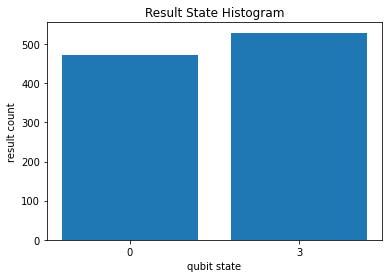

In [8]:
cirq.plot_state_histogram(result.histogram(key='m'))    

As expected, we see states 0 (ie '00') and 3 (ie '11') as the dominant results.

You may initialize both the `RigettiQCSService` and `RigettiQCSSampler` with execution functions from the `cirq_rigetti.circuit_sweep_executor` module and transformation functions from `cirq_rigetti.circuit_transformations`.

You may invoke these functions with arguments for controlling your circuit execution at a more fine grained level. For instance, you may want add [Pragma statements](https://pyquil-docs.rigetti.com/en/stable/compiler.html#region-specific-compiler-features-through-pragma){:.external} to set the [initial rewiring](https://pyquil-docs.rigetti.com/en/stable/compiler.html#initial-rewiring){:.external} strategy, invoke [active qubit reset](https://arxiv.org/abs/2001.04449){:.external} prior to execution, or explicitly address physical qubits on the quantum computer.

RESET
PRAGMA INITIAL_REWIRING "GREEDY"
DECLARE m0 BIT[2]
H 4
CNOT 4 5
MEASURE 4 m0[0]
MEASURE 5 m0[1]



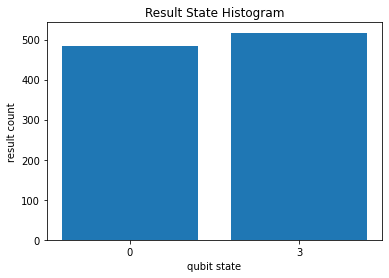

In [9]:
from pyquil.quilbase import Reset, Pragma

def hook(program, measurement_id_map):
    program._instructions.insert(0, Reset())
    program._instructions.insert(1, Pragma('INITIAL_REWIRING', freeform_string='GREEDY'))
    print(program)
    return program, measurement_id_map

# assign qubits explicitly to hardware or virtual machine qubits.
qubit_id_map = {
   qubits[0]: 4,
   qubits[1]: 5,
}
executor = circuit_sweep_executors.with_quilc_compilation_and_cirq_parameter_resolution
transformer = circuit_transformers.build(qubit_id_map=qubit_id_map, qubits=qubits, post_transformation_hooks=[hook])
service = get_rigetti_qcs_service(SERVICE_NAME, as_qvm=True, executor=executor, transformer=transformer)
result = service.run(bell_circuit, repetitions=1000)

cirq.plot_state_histogram(result.histogram(key='m'))

# Running a parameterized circuit

Of course, you may be running a parameterized circuit and would like to leverage the [Quil compilers](https://pyquil-docs.rigetti.com/en/stable/compiler.html){:.external} support for parametric compilation. This affords a speedup in execution times as the Cirq Rigetti integration will only compile the circuit once for a single parameter sweep.

We start by initializing the `RigettiQCSSampler` and specifying a circuit sweep executor that supports parametric compilation. Note, that this class accepts the same `executor` and `transformer` types as `RigettiQCSService`.

In [10]:
from cirq_rigetti import get_rigetti_qcs_sampler

executor = circuit_sweep_executors.with_quilc_parametric_compilation
sampler = get_rigetti_qcs_sampler(SERVICE_NAME, as_qvm=True, executor=executor)

Next, we will initialize a parameterized circuit in Cirq along with a set of parameter values.

In [11]:
import sympy

qubit = cirq.LineQubit.range(1)[0]

circuit = cirq.Circuit(
    cirq.H(qubit)**sympy.Symbol('t'),
    cirq.measure(qubit, key='m'))
params = cirq.Linspace('t', start=0, stop=4, length=5)

print(circuit)

0: ───H^t───M('m')───


In much the same way that we invoke, `RigettiQCSSerivce.run`, we invoke `RigettiQCSSampler.run_sweep` with our parameters here.

In [12]:
import pandas as pd

results = sampler.run_sweep(circuit, params, repetitions=10)
data = {f't={result.params["t"]}': [measurement[0] for measurement in result.measurements['m']] for result in results}

pd.DataFrame(data)

,t=0.0,t=1.0,t=2.0,t=3.0,t=4.0
0,0,0,0,1,0
1,0,1,0,0,0
2,0,0,0,1,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,1,0
6,0,1,0,0,0
7,0,1,0,1,0
8,0,0,0,1,0
9,0,0,0,0,0
